# BCS1520 Tutorial | Confidence Limits, Sampling Distributions & A First Look at Hypothesis Testing

This session walks you through:
1. Visualising sampling distributions & the Central Limit Theorem (CLT)
2. Building and interpreting confidence intervals (CIs) – for **proportions** *and* **means**
3. Linking CIs to a basic one‑sample hypothesis test
4. Practice questions with code scaffolds


## Learning objectives
By the end you should be able to:
- Explain (and demonstrate) how the CLT gives an (approximately) normal **sampling distribution of the sample mean / proportion**
- Compute a 95 % CI for a population proportion using CLT and assess its coverage with simulation
- Compute a 95 % CI for a population mean using the _t_‑distribution and the standard normal based on the z-score
- Perform a **one‑sample z‑test for a proportion** and interpret the p‑value in plain language
- Translate real text questions into Python code and statistical conclusions.

## Setup – import libraries

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
plt.style.use('ggplot')
np.random.seed(42)  # for reproducibility

## 1. Sampling distributions & the Central Limit Theorem (CLT)

Let us first draw a sample from an exponential distribution and look at the corresponding histogram. Keep in mind, that the exponential distribution can be used to model the probability of inter-arrival times between events, e.g. customers visiting a shop, data requests arriving at a database or bids for an old car you want to sell in an auction. Can you verify that the distribution of the sample is skewed, indicating that shorter inter-arrival times are more likely than longer ones?

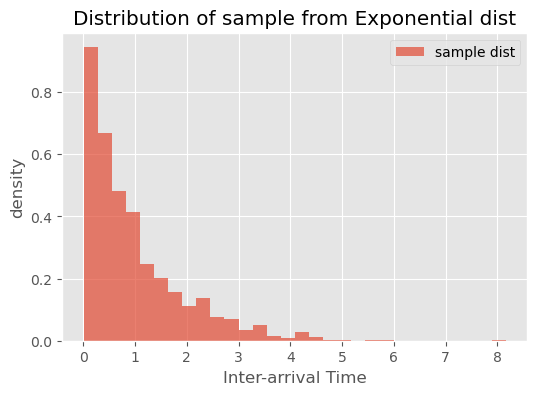

In [4]:
sample = np.random.exponential(scale=1, size=1000)
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(sample, bins=30, density=True, alpha=.7, label='sample dist')
ax.set_xlabel('Inter-arrival Time'); ax.set_ylabel('density')
ax.set_title('Distribution of sample from Exponential dist')
ax.legend()
plt.show()

The CLT (see Lecture 6 *Probability & Statistics*, slides 35‑45) tells us that for **any** population with mean $\mu$ and finite variance $\sigma^2$, the samp**LING** distribution of the *sample mean* $\bar X$ approaches $\mathcal N\!\left(\mu,\;\tfrac{\sigma}{\sqrt n}\right)$ as $n\to\infty$, regardless of the shape of each sampl**E**'s distribution.

Below, we simulate **5 000** samples of size $n=30$ from an exponential distribution and plot the distribution of the resulting means.

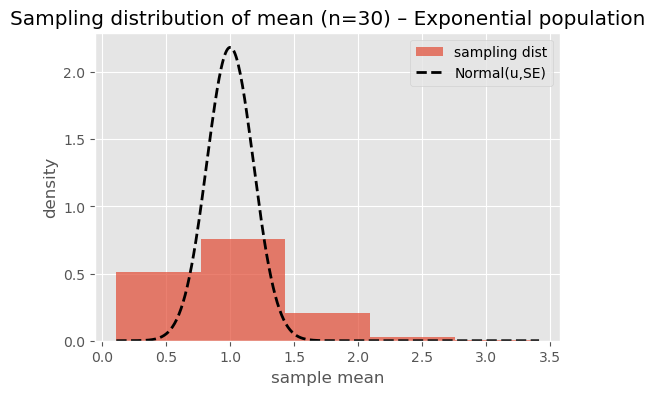

In [26]:
def sampling_dist(pop_sampler, kwargs, n=30, reps=5000):
    means = np.array([pop_sampler(**kwargs, size=n).mean() for _ in range(reps)])
    return means

exp_means = sampling_dist(np.random.exponential, kwargs={'scale':1}, n=30) # The exponential distribution takes as input the scale parameter, a.k.a. beta. Try other distributions and see what happens

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(exp_means, bins=30, density=True, alpha=.7, label='sampling dist')
mu, se = 1, 1/np.sqrt(30)  # mean and SE of Exp(1) sample mean -> this needs to change for other distributions
x = np.linspace(exp_means.min(), exp_means.max(), 400)
ax.plot(x, st.norm.pdf(x, mu, se), 'k--', lw=2, label='Normal(u,SE)')
ax.set_xlabel('sample mean'); ax.set_ylabel('density')
ax.set_title('Sampling distribution of mean (n=30) – Exponential population')
ax.legend();

**Exercise 1:** Change `n` to 5 and then to 100 in the code above. Rerun and observe how the sampling distribution evolves. Why is the histogram slightly shifted to the left when n is small? Will the histogram approach the expected normal distribution as n increases? 


**Take‑away:** 

## 2. Confidence interval for a population proportion
Suppose a survey of $n$ voters finds $X$ people in favour of a policy. Under simple random sampling the confidence interval or **CI** is
$$ \hat p \pm z_{1-\alpha/2}\,\sqrt{\dfrac{\hat p(1-\hat p)}{n}}, $$
where $\hat p=X/n$, $z$ refers to the z-score from a standard normal distribution, and $\alpha$ represents a probability. 

Below is a helper function followed by an example proportion of positive responses from a fictional survey of 1500 participants.

In [18]:
def wald_ci(x, n, alpha=0.05):
    phat = x/n
    z = st.norm.ppf(1-alpha/2)
    se = np.sqrt(phat*(1-phat)/n)
    return phat - z*se, phat + z*se

# Example: 831 say YES out of 1 500 surveyed
ci_low, ci_high = wald_ci(831, 1500)
print(f"95% CI for population proportion: ({ci_low:.3f}, {ci_high:.3f}), with center {(ci_low+ci_high)/2:.3f}")

95% CI for population proportion: (0.529, 0.579), with center 0.554


**Exercise 2** Compute the 99 % CI for the same data. What changes – the centre or the width?

**Take-away:** 

### Coverage check by simulation
Run the cell below to see how often the 95 % CI actually contains the **true** population proportion when $p=0.55$ and $n=100$.

In [62]:
def ci_coverage(proportion=0.55, n=100, reps=5000):
    covered = 0
    for _ in range(reps):
        x = np.random.binomial(n, proportion)
        lo, hi = wald_ci(x, n)
        covered += (lo <= proportion <= hi)
    return covered/reps

coverage = ci_coverage()
print(f"Empirical coverage ≈ {coverage:.3f}")

NameError: name 'wald_ci' is not defined

**Challenge:** Vary `n` and observe how the coverage behaves. For small `n` (<20) the CI can undercover the population parameter badly – a segue to better intervals (Agresti–Coull, Wilson) i.e., intervals that better cover the population parameter, in later classes.

## 3. From CI to a one‑sample **z‑test** for a proportion
We test, that is, we check whether: 
$$ H_0: p=p_0 \quad \text{vs.} \quad H_1:\; p\neq p_0, $$

This means we want to know whether the proportion fits our original expectations or not.

We use:
$$ z = \dfrac{\hat p - p_0}{\sqrt{p_0(1-p_0)/n}}. $$
And then see if $$ z > z_{1 - \frac{\alpha}{2}}$$

In [ ]:
def prop_z_test(x, n, p0, alternative='two-sided'): # IMPORTANT: Do not confuse the observed proportion phat=x/n or the hypothesized proportion p0 with the p-value that we use to indicate statistical significance
    phat = x/n
    z = (phat - p0)/np.sqrt(p0*(1-p0)/n)
    if alternative=='two-sided':
        pval = 2*(1-st.norm.cdf(abs(z)))
    elif alternative=='greater':
        pval = 1-st.norm.cdf(z)
    else:
        pval = st.norm.cdf(z)
    return z, pval

z, p = prop_z_test(x=831, n=1500, p0=0.5) # We chose p0=0.5, indicating that we hypothesize that the population proportion is 50% (null hypothesis). The alternative hypothesis is that the population proportion is not equal to 50% (two-sided test).
print(f"z = {z:.3f},  p‑value = {p:.4f}")

z = 4.183,  p‑value = 0.0000


Interpret the p‑value in context: if, in truth, exactly half of all voters support the policy, the probability of observing a sample **at least as extreme** as ours is ~…

## 4. Confidence interval for a population **mean** (unknown $\sigma$)
Suppose we are assessing the mean for a continuous-valued dataset such as the heights of people in a room. Consider the situation where we are estimating both the mean and the standard deviation. If the sample size is small, and we need to estimate **two** population parameters ($\mu$ and $\sigma$) then we use the t-distribution in order to define the confidence intervals. This distribution is better at giving coverage that is accurate at covering the population parameter for the mean $\mu$ at whatever $\alpha$ we set.

With sample size $n$ (n<30) and sample SD $s$ the 95 % CI is
$$ \bar x \pm t_{n-1,0.975}\;\dfrac{s}{\sqrt n}. $$

In [ ]:
def mean_t_ci(sample, alpha=0.05):
    n = len(sample)
    xbar = np.mean(sample)
    s = np.std(sample, ddof=1)
    tcrit = st.t.ppf(1-alpha/2, df=n-1)
    se = s/np.sqrt(n)
    return xbar - tcrit*se, xbar + tcrit*se

# Example with simulated data (n=12)
data = np.random.normal(loc=16, scale=3, size=12) 
CI_low, CI_high = mean_t_ci(data, alpha=0.05)
print(f"95% Confidence Interval for mean is: ({CI_low:.3f}, {CI_high:.3f}), with center {(CI_low+CI_high)/2:.3f}")

95% CI for mean is: (14.183, 17.771), with center 15.977


### 4.1 Confidence Interval for Population Mean (known $\sigma$)

Suppose that we have a sample size $n = 40$ and we know the standard deviation to be $\sigma = 2$ for some continuous-valued dataset. We want to know the confidence limits for the mean. In this situation (and indeed, if the sample size is 40 or greater and we didn't know the standard deviation also), we can use the z-Confidence Interval at an $\alpha = 0.05$:
$$ \bar x \pm z_{0.975}\;\dfrac{\sigma}{\sqrt n}. $$

In [26]:
n,xbar,sigma=40,502,2
se=sigma/np.sqrt(n)
print(f"Standard error is: {se:.3f}")
z_crit=st.norm.ppf(0.975)
print(f"z at 0.975 is: {z_crit:.3f}")
CI_low = xbar-z_crit*se
CI_high = xbar+z_crit*se
print(f"95% Confidence Interval for mean is: ({CI_low:.3f}, {CI_high:.3f}), with center {(CI_low+CI_high)/2:.3f}")

Standard error is: 0.316
z at 0.975 is: 1.960
95% Confidence Interval for mean is: (501.380, 502.620), with center 502.000


## 5. Few More Exercises
Complete the notebooks cells marked as exercises above. Can you use the ideas from above to answer the questions below?
Use the helper functions above or write your own. 




### Exercise 3
A sample of size $n=10$ has $\bar x =16$ and estimated $s=3$.

Compute a 95 % CI for the population mean. How much does this differ from a 99% CI?



### Exercise 4  (“Server users”)

In order to ensure efficient usage of a server, it is necessary to estimate the mean number of concurrent users. According to records, the sample mean and sample standard deviation of number of concurrent users at $17$ randomly selected times is $37.7$ and $9.2$, respectively.

a) Construct a $90%$ confidence interval for the mean number of concurrent users.

b) Do these data provide significant evidence, at 10% significance level ($\alpha$), that the mean number of concurrent users is greater than 35?

c) How would you construct a confidence interval for the standard deviation using bootstrapping?

## 6. Key take‑aways
* Sampling distributions let us quantify uncertainty due to **random sampling**
* The CLT underpins normal‑based methods (CIs, z‑tests)
* A CI gives a range of **plausible population values**; a hypothesis test gives a **p‑value** quantifying evidence against $H_0$
* Interpretation is everything – always state results in the original problem context!
